# Importing  libraries

In [2]:
import pandas as pd
import os
from sklearn.pipeline import Pipeline
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import collections
from matplotlib import rcParams
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score 
from sklearn.pipeline import Pipeline

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Loading the data

In [4]:
path='movie_reviews'

In [5]:
data=[]
target=[]

In [6]:
for dirpath,dirname,filenames in os.walk(path):
    for filename in filenames:
        category= dirpath[14:]
        target.append(category)
        file=open(f'{path}/{category}/{filename}','r')
        text=file.read()
        file.close()
        data.append(text)
print("Length of target: ",len(target))        
print("Length of dataset: ",len(data))    

Length of target:  2000
Length of dataset:  2000


# Visualizing the dataset

In [66]:
data_str = ' '.join(data)

In [67]:
type(data_str)

str

In [68]:
stopword= set(STOPWORDS)
stopword.update(['will','thing','make','think'])

In [69]:
wordcloud= WordCloud(stopwords=stopword,background_color="white", max_words=1000).generate(data_str)

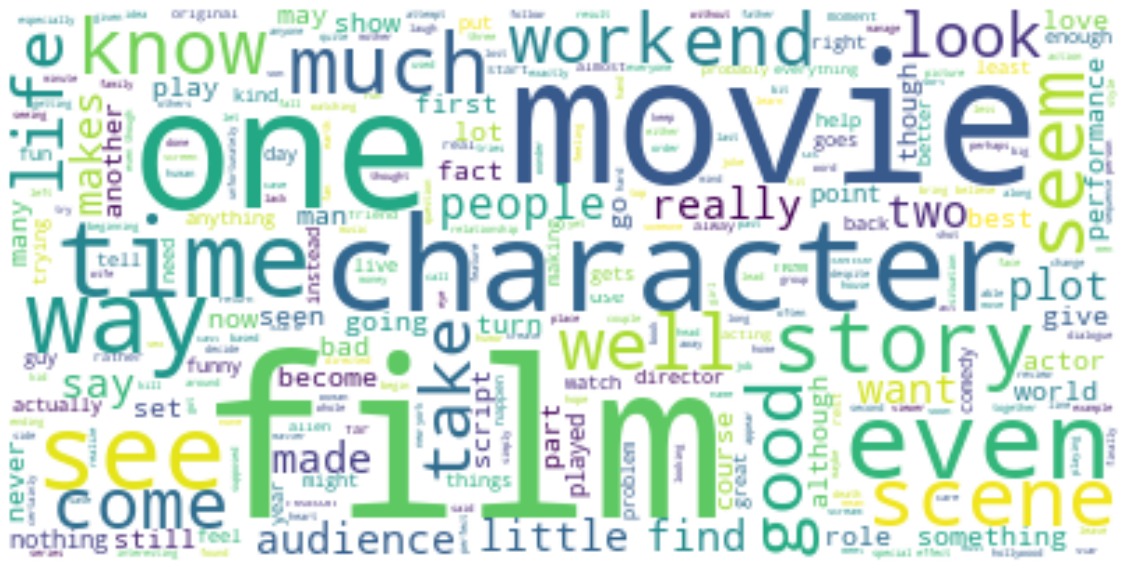

In [70]:
rcParams['figure.figsize'] = 20,30
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [71]:
filtered_words = [word for word in data_str.split() if word not in stopword]
filtered_words=[i for i in filtered_words if i.isalnum()==True]
counted_words = collections.Counter(filtered_words)
words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)

<BarContainer object of 10 artists>

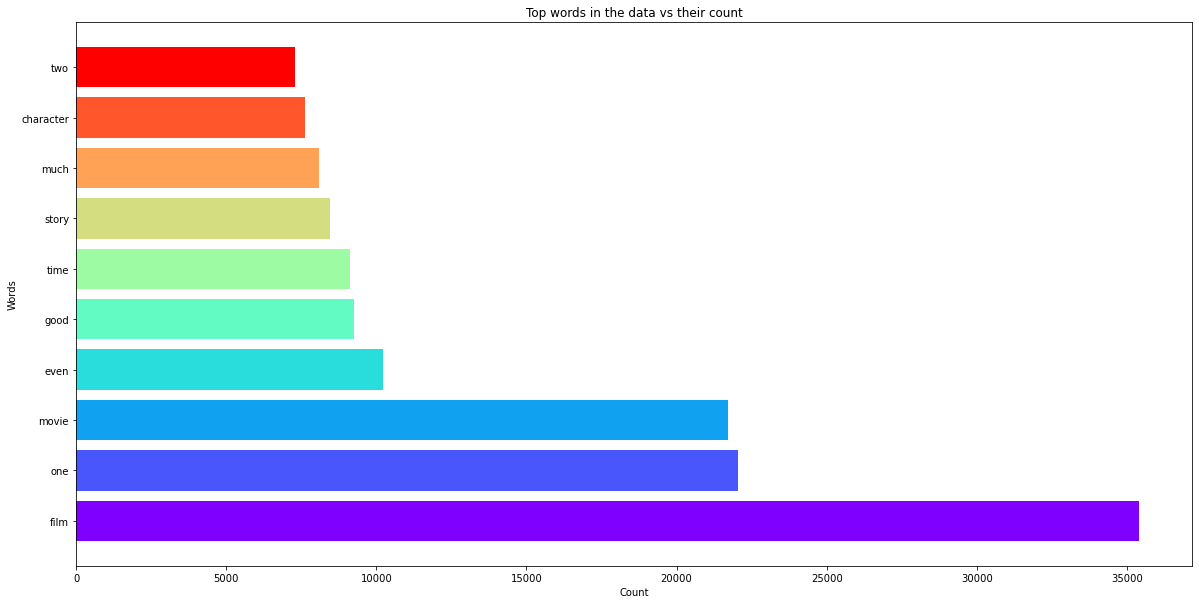

In [72]:
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the data vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

# Applying stemming and lemmatization


In [7]:
porter=PorterStemmer()
lemme=WordNetLemmatizer()

In [8]:
def stemming(review):
    sentence= [porter.stem(word) for word in word_tokenize(review)]
    sentence= [lemme.lemmatize(word) for word in word_tokenize(review)]
    sentence = ' '.join(sentence)
    return sentence

In [9]:
reviews=[]
for j in range(len(data)):
    reviews.append(stemming(data[j]))

In [10]:
print("Length of the dataset: ",len(reviews))

Length of the dataset:  2000


# Splitting the dataset

In [33]:
trainx,testx,trainy,testy= train_test_split(reviews,target,test_size=0.25,random_state=0)

In [78]:
print("Length of training data:",len(trainx))
print("Length of testing data:",len(testx))

Length of training data: 1500
Length of testing data: 500


In [35]:
tfidf=TfidfVectorizer(use_idf=True,stop_words='english',analyzer='word',token_pattern=r'(?u)\b[A-Za-z]+\b')
tfidf.fit(trainx)
word_features_trainx= tfidf.transform(trainx)
word_features_testx=tfidf.transform(testx)

In [80]:
print("Length of features:",len(tfidf.get_feature_names()))

Length of features: 30745


In [81]:
print("Shape of training dataset:",word_features_trainx.shape)
print("Shape of testing dataset:",word_features_testx.shape)

Shape of training dataset: (1500, 30745)
Shape of testing dataset: (500, 30745)


In [82]:
dict_tfidf=dict(zip(tfidf.get_feature_names(),tfidf.idf_))
common= collections.Counter(dict_tfidf)
a=[]
b=[]
for i,j in common.most_common(6):
    a.append(i)
    b.append(j)    

In [115]:
len(dict_tfidf)

30745

In [110]:
c,d=[],[]

In [112]:
for k,f in common.most_common(23000):
    if f not in d:
        c.append(k)
        d.append(f)      

['aaaaaaaahhhh', 'aa', 'aaliyah', 'abel', 'abduction', 'abode'] [7.620739651073516, 7.215274542965353, 6.927592470513571, 6.704448919199361, 6.522127362405407, 6.367976682578148]


Text(0.5, 0, 'inverse document frequency')

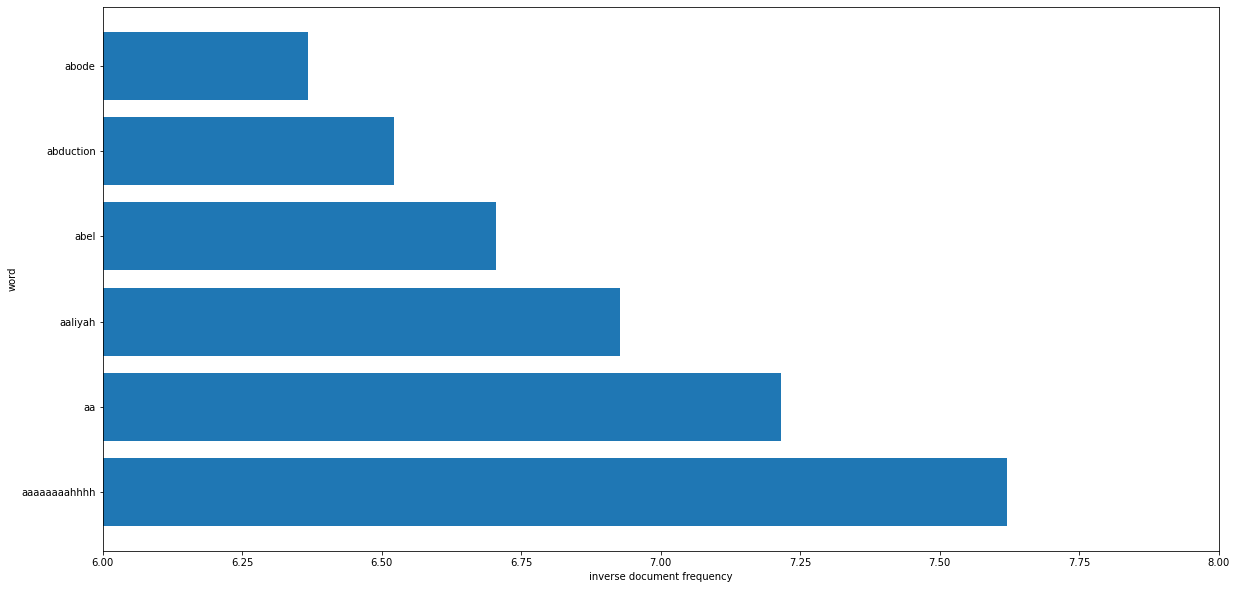

In [118]:
plt.xlim((6,8))
plt.barh(c,d)
plt.ylabel("word")
plt.xlabel("inverse document frequency")

# Checking models

1. SVC

In [41]:
model= SVC()
score=cross_val_score(model,word_features_trainx,trainy)
np.mean(score)

0.7866666666666665

In [42]:
params= {'C':[1,10,20],'kernel': ['rbf','linear']}
tuning= GridSearchCV(model,params,cv=5)
tuning.fit(word_features_trainx,trainy)
df_tuning= pd.DataFrame(tuning.cv_results_)
df_tuning

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.573928,0.034743,1.123202,0.009866,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.783333,0.786667,0.820000,0.763333,0.780000,0.786667,0.018499,6
1,4.774416,0.409593,1.130894,0.133293,1,linear,"{'C': 1, 'kernel': 'linear'}",0.816667,0.803333,0.843333,0.796667,0.793333,0.810667,0.018184,3
2,5.145253,0.341090,1.219296,0.041455,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.796667,0.803333,0.826667,0.770000,0.806667,0.800667,0.018306,4
3,4.945409,0.094866,1.110722,0.057020,10,linear,"{'C': 10, 'kernel': 'linear'}",0.830000,0.816667,0.866667,0.790000,0.800000,0.820667,0.026783,1
4,5.744130,0.117732,1.322882,0.070044,20,rbf,"{'C': 20, 'kernel': 'rbf'}",0.796667,0.803333,0.826667,0.770000,0.806667,0.800667,0.018306,4
5,4.857849,0.228550,1.029602,0.048335,20,linear,"{'C': 20, 'kernel': 'linear'}",0.830000,0.816667,0.866667,0.790000,0.800000,0.820667,0.026783,1


In [119]:
print("Best parameters:",tuning.best_params_)
print("Best Score:",tuning.best_score_)

Best parameters: {'C': 10, 'kernel': 'linear'}
Best Score: 0.8206666666666667


In [44]:
model_nb= MultinomialNB()
score_nb=cross_val_score(model_nb,word_features_trainx,trainy)
np.mean(score_nb)

0.7933333333333333

In [120]:
params_nb= {'alpha': np.linspace(0.5,1.5,6),'fit_prior':[True,False]}
tuning_nb= GridSearchCV(model_nb,params_nb,cv=5)
tuning_nb.fit(word_features_trainx,trainy)
print("Best parameters:",tuning_nb.best_params_)
print("Best Score:",tuning_nb.best_score_)

Best parameters: {'alpha': 0.9, 'fit_prior': True}
Best Score: 0.7953333333333334


CONCLUSION-
SVC has better accuaracy than MultinomialNB, So we are using SVC to make predictions

In [121]:
ypred=tuning.predict(word_features_testx)
print("Length of predicted values of testing data:",len(ypred))

Length of predicted values of testing data: 500


# Evaluating our Model

In [126]:
accuracy= accuracy_score(testy,ypred)
accuracy

0.842

In [127]:
report= classification_report(testy,ypred,output_dict=True)
report

{'neg': {'precision': 0.848605577689243,
  'recall': 0.8385826771653543,
  'f1-score': 0.8435643564356435,
  'support': 254},
 'pos': {'precision': 0.8353413654618473,
  'recall': 0.8455284552845529,
  'f1-score': 0.8404040404040405,
  'support': 246},
 'accuracy': 0.842,
 'macro avg': {'precision': 0.8419734715755451,
  'recall': 0.8420555662249536,
  'f1-score': 0.841984198419842,
  'support': 500},
 'weighted avg': {'precision': 0.8420795852733644,
  'recall': 0.842,
  'f1-score': 0.8420094809480947,
  'support': 500}}

In [128]:
cm= confusion_matrix(testy,ypred)
cm

array([[213,  41],
       [ 38, 208]], dtype=int64)

<AxesSubplot:>

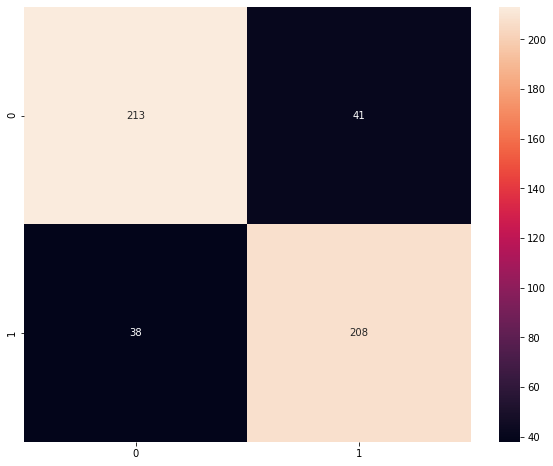

In [132]:
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d')

Prediction on a random test data

In [123]:
prediction= tuning.predict(word_features_testx[2])
print("Model prediction:",prediction)

Model prediction: ['pos']


In [124]:
actual_ans= testy[2]
print("actual prediction:",actual_ans)

actual prediction: pos


This depicts that our model is working fine 